In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

from library.sb_utils import save_file

In [3]:
data='../ski_data_clean_data/ski_data_step3_features.csv'
ski_data = pd.read_csv(data)

In [4]:
ski_data.head().T

,0,1,2,3,4
Name,Alyeska Resort,Eaglecrest Ski Area,Hilltop Ski Area,Arizona Snowbowl,Sunrise Park Resort
Region,Alaska,Alaska,Alaska,Arizona,Arizona
state,Alaska,Alaska,Alaska,Arizona,Arizona
summit_elev,3939,2600,2090,11500,11100
vertical_drop,2500,1540,294,2300,1800
base_elev,250,1200,1796,9200,9200
trams,1,0,0,0,0
fastSixes,0,0,0,1,0
fastQuads,2,0,0,0,1
quad,2,0,0,2,2


In [5]:
ski_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Name                                277 non-null    object 
 1   Region                              277 non-null    object 
 2   state                               277 non-null    object 
 3   summit_elev                         277 non-null    int64  
 4   vertical_drop                       277 non-null    int64  
 5   base_elev                           277 non-null    int64  
 6   trams                               277 non-null    int64  
 7   fastSixes                           277 non-null    int64  
 8   fastQuads                           277 non-null    int64  
 9   quad                                277 non-null    int64  
 10  triple                              277 non-null    int64  
 11  double                              277 non-n

## Extract Big Mountain Data

Big Mountain is your resort. Separate it from the rest of the data to use later.

In [6]:
big_mountain = ski_data[ski_data.Name == 'Big Mountain Resort']

In [7]:
big_mountain.T

,124
Name,Big Mountain Resort
Region,Montana
state,Montana
summit_elev,6817
vertical_drop,2353
base_elev,4464
trams,0
fastSixes,0
fastQuads,3
quad,2


In [8]:
ski_data.shape

(277, 36)

In [9]:
#Big Mountain is our resort. Separate it from the rest of the data to use later:
ski_data = ski_data[ski_data.Name != 'Big Mountain Resort']

In [10]:
ski_data.shape

(276, 36)

## 4.6 Train/Test Split

So far, you've treated ski resort data as a single entity. In machine learning, when you train your model on all of your data, you end up with no data set aside to evaluate model performance. You could keep making more and more complex models that fit the data better and better and not realise you were overfitting to that one set of samples. By partitioning the data into training and testing splits, without letting a model (or missing-value imputation) learn anything about the test split, you have a somewhat independent assessment of how your model might perform in the future. An often overlooked subtlety here is that people all too frequently use the test set to assess model performance and then compare multiple models to pick the best. This means their overall model selection process is fitting to one specific data set, now the test split. You could keep going, trying to get better and better performance on that one data set, but that's where cross-validation becomes especially useful. While training models, a test split is very useful as a final check on expected future performance.

What partition sizes would you have with a 70/30 train/test split?

In [11]:
len(ski_data) * .7, len(ski_data) * .3

(193.2, 82.8)

In [12]:

X_train, X_test, y_train, y_test = train_test_split(ski_data.drop(columns='AdultWeekend'), ski_data.AdultWeekend, test_size=0.3, random_state=47)

#ski_data will be split on 70% (X_train) to 30% (X_test) where columns='AdultWeekend' will be dropped.
#ski_data.AdultWeekend "column" will be split on 70% (y_train) to 30% (y_test)

In [13]:
X_train.T

,108,96,189,232,1,36,240,252,132,107,...,174,71,264,209,59,23,180,72,265,136
Name,Powder Ridge Ski Area,The Homestead,Beech Mountain Resort,Solitude Mountain Resort,Eaglecrest Ski Area,Bogus Basin,Magic Mountain,White Pass,Cannon Mountain,Mount Kato Ski Area,...,Royal Mountain Ski Area,Ski Butternut,Mount La Crosse,Camelback Mountain Resort,Shawnee Peak,Monarch Mountain,Toggenburg Mountain,Wachusett Mountain Ski Area,Nordic Mountain,King Pine
Region,Minnesota,Michigan,North Carolina,Salt Lake City,Alaska,Idaho,Vermont,Washington,New Hampshire,Minnesota,...,New York,Massachusetts,Wisconsin,Pennsylvania,Maine,Colorado,New York,Massachusetts,Wisconsin,New Hampshire
state,Minnesota,Michigan,North Carolina,Utah,Alaska,Idaho,Vermont,Washington,New Hampshire,Minnesota,...,New York,Massachusetts,Wisconsin,Pennsylvania,Maine,Colorado,New York,Massachusetts,Wisconsin,New Hampshire
summit_elev,790,900,5506,10488,2600,7582,2850,6550,4080,540,...,1800,1800,1110,2100,1900,11952,2000,2006,1137,850
vertical_drop,300,320,830,2494,1540,1800,1500,2050,2180,240,...,550,1000,516,800,1350,1162,700,1000,265,350
base_elev,500,580,4675,7994,1200,5800,1350,4500,1900,300,...,1250,800,594,1250,600,10790,1300,1006,872,500
trams,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
fastSixes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fastQuads,0,0,0,4,0,3,0,2,1,0,...,0,0,0,2,0,0,0,3,0,0
quad,1,0,3,2,0,0,0,1,2,5,...,0,3,0,0,1,1,0,0,0,0


In [14]:
y_train

108     48.0
96      50.0
189     68.0
232    119.0
1       53.0
       ...  
23      89.0
180     55.0
72      71.0
265     47.0
136     58.0
Name: AdultWeekend, Length: 193, dtype: float64

In [15]:
y_test

119     39.0
195     44.0
115     63.0
102     37.0
167     59.0
       ...  
223    116.0
76      48.0
241     81.0
254     87.0
45      71.0
Name: AdultWeekend, Length: 83, dtype: float64

In [16]:
X_train.shape, X_test.shape

((193, 35), (83, 35))

In [17]:
((193,), (83,))

((193,), (83,))

In [18]:
#Save the 'Name', 'state', and 'Region' columns from the train/test data into names_train and names_test
#Then drop those columns from `X_train` and `X_test`. Use 'inplace=True'
names_list = ['Name', 'state', 'Region']
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

((193, 32), (83, 32))

In [19]:
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

summit_elev                             int64
vertical_drop                           int64
base_elev                               int64
trams                                   int64
fastSixes                               int64
fastQuads                               int64
quad                                    int64
triple                                  int64
double                                  int64
surface                                 int64
total_chairs                            int64
Runs                                  float64
TerrainParks                          float64
LongestRun_mi                         float64
SkiableTerrain_ac                     float64
Snow Making_ac                        float64
daysOpenLastYear                      float64
yearsOpen                               int64
averageSnowfall                       float64
projectedDaysOpen                     float64
NightSkiing_ac                        float64
resorts_per_state                 

In [20]:
#Repeat this check for the test split in `X_test`
X_test.dtypes

summit_elev                             int64
vertical_drop                           int64
base_elev                               int64
trams                                   int64
fastSixes                               int64
fastQuads                               int64
quad                                    int64
triple                                  int64
double                                  int64
surface                                 int64
total_chairs                            int64
Runs                                  float64
TerrainParks                          float64
LongestRun_mi                         float64
SkiableTerrain_ac                     float64
Snow Making_ac                        float64
daysOpenLastYear                      float64
yearsOpen                               int64
averageSnowfall                       float64
projectedDaysOpen                     float64
NightSkiing_ac                        float64
resorts_per_state                 

You have only numeric features in your X now!

## 4.7 Initial Not-Even-A-Model

A good place to start is to see how good the mean is as a predictor. In other words, what if you simply say your best guess is the average price?

In [21]:
#Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

63.811088082901556

In [22]:
#Calculate the mean of `y_train`
y_test_mean = y_test.mean()
y_test_mean

65.1566265060241

sklearn's DummyRegressor easily does this:

In [23]:
#Fit the dummy regressor on the training data
#Hint, call its `.fit()` method with `X_train` and `y_train` as arguments
#Then print the object's `constant_` attribute and verify it's the same as the mean above
#DummyRegressor(strategy='str') : predicts the "Mean, Median, quantile , constant" of the trainging set:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[63.81108808]])

How good is this? How closely does this match, or explain, the actual values? There are many ways of assessing how good one set of values agrees with another, which brings us to the subject of metrics.

## 4.7.1 Metrics

#### 4.7.1.1 R-squared, or coefficient of determination

One measure is  𝑅2
 , the coefficient of determination. This is a measure of the proportion of variance in the dependent variable (our ticket price) that is predicted by our "model". The linked Wikipedia articles gives a nice explanation of how negative values can arise. This is frequently a cause of confusion for newcomers who, reasonably, ask how can a squared value be negative?

Recall the mean can be denoted by  𝑦¯
 , where

𝑦¯=1𝑛∑𝑖=1𝑛𝑦𝑖
 
and where  𝑦𝑖
  are the individual values of the dependent variable.

The total sum of squares (error), can be expressed as

𝑆𝑆𝑡𝑜𝑡=∑𝑖(𝑦𝑖−𝑦¯)2
 
The above formula should be familiar as it's simply the variance without the denominator to scale (divide) by the sample size.

The residual sum of squares is similarly defined to be

𝑆𝑆𝑟𝑒𝑠=∑𝑖(𝑦𝑖−𝑦̂ )2
 
where  𝑦̂ 
  are our predicted values for the depended variable.

The coefficient of determination,  𝑅2
 , here is given by

𝑅2=1−𝑆𝑆𝑟𝑒𝑠𝑆𝑆𝑡𝑜𝑡
 
Putting it into words, it's one minus the ratio of the residual variance to the original variance. Thus, the baseline model here, which always predicts  𝑦¯
 , should give  𝑅2=0
 . A model that perfectly predicts the observed values would have no residual error and so give  𝑅2=1
 . Models that do worse than predicting the mean will have increased the sum of squares of residuals and so produce a negative  𝑅2
 .

In [24]:
#Calculate the R^2 as defined above
def r_squared(y, ypred):
    """R-squared score.
    
    Calculate the R-squared, or coefficient of determination, of the input.
    
    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    ybar = np.sum(y) / len(y) #yes, we could use np.mean(y)
    sum_sq_tot = np.sum((y - ybar)**2) #total sum of squares error
    sum_sq_res = np.sum((y - ypred)**2) #residual sum of squares error
    R2 = 1.0 - sum_sq_res / sum_sq_tot
    return R2

Make your predictions by creating an array of length the size of the training set with the single value of the mean.

In [25]:
y_tr_pred_ = train_mean * np.ones(len(y_train))
y_tr_pred_[:5]

array([63.81108808, 63.81108808, 63.81108808, 63.81108808, 63.81108808])

Remember the sklearn dummy regressor?

In [26]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([63.81108808, 63.81108808, 63.81108808, 63.81108808, 63.81108808])

You can see that DummyRegressor produces exactly the same results and saves you having to mess about broadcasting the mean (or whichever other statistic we used - check out the documentation to see what's available) to an array of the appropriate length. It also gives you an object with fit() and predict() methods as well so you can use them as conveniently as any other sklearn estimator.

In [27]:
r_squared(y_train, y_tr_pred)

0.0

Exactly as expected, if you use the average value as your prediction, you get an  𝑅2
  of zero on our training set. What if you use this "model" to predict unseen values from the test set? Remember, of course, that your "model" is trained on the training set; you still use the training set mean as your prediction.

Make your predictions by creating an array of length the size of the test set with the single value of the (training) mean.

In [28]:
y_te_pred = train_mean * np.ones(len(y_test))
r_squared(y_test, y_te_pred)

-0.0031235200417913944

Generally, you can expect performance on a test set to be slightly worse than on the training set. As you are getting an  𝑅2
  of zero on the training set, there's nowhere to go but negative!

𝑅2
  is a common metric, and interpretable in terms of the amount of variance explained, it's less appealing if you want an idea of how "close" your predictions are to the true values. Metrics that summarise the difference between predicted and actual values are mean absolute error and mean squared error.

## 4.7.1.2 Mean Absolute Error

This is very simply the average of the absolute errors:

𝑀𝐴𝐸=1𝑛∑𝑖𝑛|𝑦𝑖−𝑦̂ |

In [29]:
#Calculate the MAE as defined above
def mae(y, ypred):
    """Mean absolute error.
    
    Calculate the mean absolute error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    abs_error = np.abs(y - ypred)
    mae = np.mean(abs_error)
    return mae

In [30]:
mae(y_train, y_tr_pred)

17.92346371714677

In [31]:
mae(y_test, y_te_pred)

19.136142081278486

Mean absolute error is arguably the most intuitive of all the metrics, this essentially tells you that, on average, you might expect to be off by around $19 if you guessed ticket price based on an average of known values.

In [32]:
### 4.7.1.3 Mean Squared Error

Another common metric (and an important one internally for optimizing machine learning models) is the mean squared error. This is simply the average of the square of the errors:

𝑀𝑆𝐸=1𝑛∑𝑖𝑛(𝑦𝑖−𝑦̂ )2

In [33]:
#Calculate the MSE as defined above
def mse(y, ypred):
    """Mean square error.
    
    Calculate the mean square error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    sq_error = (y - ypred)**2
    mse = np.mean(sq_error)
    return mse

In [34]:
mse(y_train, y_tr_pred)

614.1334096969046

In [35]:
mse(y_test, y_te_pred)

581.4365441953483

So here, you get a slightly better MSE on the test set than you did on the train set. And what does a squared error mean anyway? To convert this back to our measurement space, we often take the square root, to form the root mean square error thus:

In [36]:
np.sqrt([mse(y_train, y_tr_pred), mse(y_test, y_te_pred)])

array([24.78171523, 24.11299534])

## 4.7.2 sklearn metrics

Functions are good, but you don't want to have to define functions every time we want to assess performance. sklearn.metrics provides many commonly used metrics, included the ones above.

#### 4.7.2.0.1 R-squared

In [38]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.0031235200417913944)

#### 4.7.2.0.2 Mean absolute error

In [39]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(17.92346371714677, 19.136142081278486)

### 4.7.2.0.3 Mean squared error

In [40]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(614.1334096969046, 581.4365441953483)

## 4.7.3 Note On Calculating Metrics

When calling functions to calculate metrics, it is important to take care in the order of the arguments. Two of the metrics above actually don't care if the arguments are reversed; one does. Which one cares?

In a Jupyter code cell, running r2_score? will bring up the docstring for the function, and r2_score?? will bring up the actual code of the function! Try them and compare the source for sklearn's function with yours. Feel free to explore what happens when you reverse the order of the arguments and compare behaviour of sklearn's function and yours.

In [41]:
# train set - sklearn
# correct order, incorrect order
r2_score(y_train, y_tr_pred), r2_score(y_tr_pred, y_train)

(0.0, -3.041041349306602e+30)

In [42]:
# test set - sklearn
# correct order, incorrect order
r2_score(y_test, y_te_pred), r2_score(y_te_pred, y_test)

(-0.0031235200417913944, 0.0)

In [43]:
# test set - using our homebrew function
# correct order, incorrect order
r_squared(y_test, y_te_pred), r_squared(y_te_pred, y_test)

C:\Users\khara\AppData\Local\Temp\ipykernel_92640\94046847.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  R2 = 1.0 - sum_sq_res / sum_sq_tot


(-0.0031235200417913944, -inf)

You can get very different results swapping the argument order. It's worth highlighting this because data scientists do this too much in the real world! Don't be one of them! Frequently the argument order doesn't matter, but it will bite you when you do it with a function that does care. It's sloppy, bad practice and if you don't make a habit of putting arguments in the right order, you will forget!

Remember:

argument order matters,
check function syntax with func? in a code cell

## 4.8 Initial Models

## 4.8.1 Imputing missing feature (predictor) values

Recall when performing EDA, you imputed (filled in) some missing values in pandas. You did this judiciously for exploratory/visualization purposes. You left many missing values in the data. You can impute missing values using scikit-learn, but note that you should learn values to impute from a train split and apply that to the test split to then assess how well your imputation worked.

#### 4.8.1.1 Impute missing values with median

There's missing values. Recall from your data exploration that many distributions were skewed. Your first thought might be to impute missing values using the median.

### 4.8.1.1.1 Learn the values to impute from the train set

In [44]:
# These are the values we'll use to fill in any missing values
X_defaults_median = X_train.median()
X_defaults_median

summit_elev                           2215.000000
vertical_drop                          750.000000
base_elev                             1300.000000
trams                                    0.000000
fastSixes                                0.000000
fastQuads                                0.000000
quad                                     1.000000
triple                                   1.000000
double                                   1.000000
surface                                  2.000000
total_chairs                             7.000000
Runs                                    28.000000
TerrainParks                             2.000000
LongestRun_mi                            1.000000
SkiableTerrain_ac                      170.000000
Snow Making_ac                          96.500000
daysOpenLastYear                       109.000000
yearsOpen                               57.000000
averageSnowfall                        120.000000
projectedDaysOpen                      115.000000


#### 4.8.1.1.2 Apply the imputation to both train and test splits

In [45]:
#Call `X_train` and `X_test`'s `fillna()` method, passing `X_defaults_median` as the values to use
#Assign the results to `X_tr` and `X_te`, respectively
X_tr = X_train.fillna(X_defaults_median)
X_te = X_test.fillna(X_defaults_median)

### 4.8.1.1.3 Scale the data

As you have features measured in many different units, with numbers that vary by orders of magnitude, start off by scaling them to put them all on a consistent scale. The StandardScaler scales each feature to zero mean and unit variance.

In [47]:
#Call the StandardScaler`s fit method on `X_tr` to fit the scaler
#then use it's `transform()` method to apply the scaling to both the train and test split
#data (`X_tr` and `X_te`), naming the results `X_tr_scaled` and `X_te_scaled`, respectively
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

#### 4.8.1.1.4 Train the model on the train split

In [48]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

#### 4.8.1.1.5 Make predictions using the model on both train and test splits

In [49]:
#Call the `predict()` method of the model (`lm`) on both the (scaled) train and test data
#Assign the predictions to `y_tr_pred` and `y_te_pred`, respectively
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

### 4.8.1.1.6 Assess model performance

In [50]:
# r^2 - train, test
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.8177988516610304, 0.7209725861360246)

Recall that you estimated ticket price by simply using a known average. As expected, this produced an  𝑅2
  of zero for both the training and test set, because  𝑅2
  tells us how much of the variance you're explaining beyond that of using just the mean, and you were using just the mean. Here we see that our simple linear regression model explains over 80% of the variance on the train set and over 70% on the test set. Clearly you are onto something, although the much lower value for the test set suggests you're overfitting somewhat. This isn't a surprise as you've made no effort to select a parsimonious set of features or deal with multicollinearity in our data.

In [51]:
#Now calculate the mean absolute error scores using `sklearn`'s `mean_absolute_error` function
# as we did above for R^2
# MAE - train, test
median_mae = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_mae

(0.8177988516610304, 0.7209725861360246)

Using this model, then, on average you'd expect to estimate a ticket price within $9 or so of the real price. This is much, much better than the $19 from just guessing using the average. There may be something to this machine learning lark after all!

In [52]:
#And also do the same using `sklearn`'s `mean_squared_error`
# MSE - train, test
median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
median_mse

(111.89581248010295, 161.73156347293715)

#### 4.8.1.2 Impute missing values with the mean

You chose to use the median for filling missing values because of the skew of many of our predictor feature distributions. What if you wanted to try something else, such as the mean?

### 4.8.1.2.1 Learn the values to impute from the train set

In [53]:
#As we did for the median above, calculate mean values for imputing missing values
# These are the values we'll use to fill in any missing values
X_defaults_mean = X_train.mean()
X_defaults_mean

summit_elev                           4074.554404
vertical_drop                         1043.196891
base_elev                             3020.512953
trams                                    0.103627
fastSixes                                0.072539
fastQuads                                0.673575
quad                                     1.010363
triple                                   1.440415
double                                   1.813472
surface                                  2.497409
total_chairs                             7.611399
Runs                                    41.188482
TerrainParks                             2.434783
LongestRun_mi                            1.293122
SkiableTerrain_ac                      448.785340
Snow Making_ac                         129.601190
daysOpenLastYear                       110.100629
yearsOpen                               56.559585
averageSnowfall                        162.310160
projectedDaysOpen                      115.920245


By eye, you can immediately tell that your replacement values are much higher than those from using the median.

### 4.8.1.2.2 Apply the imputation to both train and test splits

In [54]:
X_tr = X_train.fillna(X_defaults_mean)
X_te = X_test.fillna(X_defaults_mean)

#### 4.8.1.2.3 Scale the data

In [55]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

#### 4.8.1.2.4 Train the model on the train split

In [56]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

### 4.8.1.2.5 Make predictions using the model on both train and test splits

In [57]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

### 4.8.1.2.6 Assess model performance

In [58]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.8170154094964696, 0.7163814740221734)

In [59]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(8.536884039968788, 9.416375593748034)

In [60]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(112.37695048792496, 164.39269174693052)

These results don't seem very different to when you used the median for imputing missing values. Perhaps it doesn't make much difference here. Maybe your overtraining dominates. Maybe other feature transformations, such as taking the log, would help. You could try with just a subset of features rather than using all of them as inputs.

To perform the median/mean comparison, you copied and pasted a lot of code just to change the function for imputing missing values. It would make more sense to write a function that performed the sequence of steps:

impute missing values
scale the features
train a model
calculate model performance
But these are common steps and sklearn provides something much better than writing custom functions.

### 4.8.2 Pipelines

One of the most important and useful components of sklearn is the pipeline. In place of panda's fillna DataFrame method, there is sklearn's SimpleImputer. Remember the first linear model above performed the steps:

replace missing values with the median for each feature
scale the data to zero mean and unit variance
train a linear regression model
and all these steps were trained on the train split and then applied to the test split for assessment.

The pipeline below defines exactly those same steps. Crucially, the resultant Pipeline object has a fit() method and a predict() method, just like the LinearRegression() object itself. Just as you might create a linear regression model and train it with .fit() and predict with .predict(), you can wrap the entire process of imputing and feature scaling and regression in a single object you can train with .fit() and predict with .predict(). And that's basically a pipeline: a model on steroids.

#### 4.8.2.1 Define the pipeline

In [61]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    LinearRegression()
)

In [62]:
type(pipe)

sklearn.pipeline.Pipeline

In [63]:
hasattr(pipe, 'fit'), hasattr(pipe, 'predict')

(True, True)

#### 4.8.2.2 Fit the pipeline

Here, a single call to the pipeline's fit() method combines the steps of learning the imputation (determining what values to use to fill the missing ones), the scaling (determining the mean to subtract and the variance to divide by), and then training the model. It does this all in the one call with the training data as arguments.

In [64]:
#Code task 15#
#Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

### 4.8.2.3 Make predictions on the train and test sets

In [65]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

### 4.8.2.4 Assess performance

In [66]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.8177988516610304, 0.7209725861360246)

And compare with your earlier (non-pipeline) result:

In [67]:
median_r2

(0.8177988516610304, 0.7209725861360246)

In [68]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(8.547850299071076, 9.407020102572671)

Compare with your earlier result:

In [70]:
median_mae

(0.8177988516610304, 0.7209725861360246)

In [71]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(111.89581248010295, 161.73156347293715)

These results confirm the pipeline is doing exactly what's expected, and results are identical to your earlier steps. This allows you to move faster but with confidence.

##  4.9 Refining The Linear Model

You suspected the model was overfitting. This is no real surprise given the number of features you blindly used. It's likely a judicious subset of features would generalize better. sklearn has a number of feature selection functions available. The one you'll use here is SelectKBest which, as you might guess, selects the k best features. You can read about SelectKBest here. f_regression is just the score function you're using because you're performing regression. It's important to choose an appropriate one for your machine learning task.

#### 4.9.1 Define the pipeline

Redefine your pipeline to include this feature selection step:

In [73]:
#Add `SelectKBest` as a step in the pipeline between `StandardScaler()` and `LinearRegression()`
#Don't forget to tell it to use `f_regression` as its score function
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

### 4.9.2 Fit the pipeline

In [74]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x000002B4E0717560>)),
                ('linearregression', LinearRegression())])

### 4.9.3 Assess performance on the train and test set

In [75]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [76]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.7674914326052744, 0.6259877354190837)

In [77]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(9.501495079727485, 11.20183019033205)

This has made things worse! Clearly selecting a subset of features has an impact on performance. SelectKBest defaults to k=10. You've just seen that 10 is worse than using all features. What is the best k? You could create a new pipeline with a different value of k:

## 4.9.4 Define a new pipeline to select a different number of features

In [78]:
#Modify the `SelectKBest` step to use a value of 15 for k
pipe15 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression, k=15),
    LinearRegression()
)

## 4.9.5 Fit the pipeline

In [79]:
pipe15.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x000002B4E0717560>)),
                ('linearregression', LinearRegression())])

### 4.9.6 Assess performance on train and test data

In [80]:
y_tr_pred = pipe15.predict(X_train)
y_te_pred = pipe15.predict(X_test)

In [81]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.7924096060461918, 0.63761999743376)

In [82]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(9.211767769521186, 10.488246866068684)

You could keep going, trying different values of k, training a model, measuring performance on the test set, and then picking the model with the best test set performance. There's a fundamental problem with this approach: you're tuning the model to the arbitrary test set! If you continue this way you'll end up with a model works well on the particular quirks of our test set but fails to generalize to new data. The whole point of keeping a test set is for it to be a set of that new data, to check how well our model might perform on data it hasn't seen.

The way around this is a technique called cross-validation. You partition the training set into k folds, train our model on k-1 of those folds, and calculate performance on the fold not used in training. This procedure then cycles through k times with a different fold held back each time. Thus you end up building k models on k sets of data with k estimates of how the model performs on unseen data but without having to touch the test set.

### 4.9.7 Assessing performance using cross-validation

In [83]:
cv_results = cross_validate(pipe15, X_train, y_train, cv=5)

In [84]:
cv_scores = cv_results['test_score']
cv_scores

array([0.63760862, 0.72831381, 0.74443537, 0.5487915 , 0.50441472])

Without using the same random state for initializing the CV folds, your actual numbers will be different.

In [85]:
np.mean(cv_scores), np.std(cv_scores)

(0.6327128051032801, 0.0950248786395634)

These results highlight that assessing model performance in inherently open to variability. You'll get different results depending on the quirks of which points are in which fold. An advantage of this is that you can also obtain an estimate of the variability, or uncertainty, in your performance estimate.

In [86]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([0.44, 0.82])

## 4.9.8 Hyperparameter search using GridSearchCV

Pulling the above together, we have:

a pipeline that
imputes missing values
scales the data
selects the k best features
trains a linear regression model
a technique (cross-validation) for estimating model performance
Now you want to use cross-validation for multiple values of k and use cross-validation to pick the value of k that gives the best performance. make_pipeline automatically names each step as the lowercase name of the step and the parameters of the step are then accessed by appending a double underscore followed by the parameter name. You know the name of the step will be 'selectkbest' and you know the parameter is 'k'.

You can also list the names of all the parameters in a pipeline like this:

In [87]:
#Code task 18#
#Call `pipe`'s `get_params()` method to get a dict of available parameters and print their names
#using dict's `keys()` method
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__keep_empty_features', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__positive'])

The above can be particularly useful as your pipelines becomes more complex (you can even nest pipelines within pipelines).

In [88]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

Now you have a range of k to investigate. Is 1 feature best? 2? 3? 4? All of them? You could write a for loop and iterate over each possible value, doing all the housekeeping oyurselves to track the best value of k. But this is a common task so there's a built in function in sklearn. This is GridSearchCV. This takes the pipeline object, in fact it takes anything with a .fit() and .predict() method. In simple cases with no feature selection or imputation or feature scaling etc. you may see the classifier or regressor object itself directly passed into GridSearchCV. The other key input is the parameters and values to search over. Optional parameters include the cross-validation strategy and number of CPUs to use.

In [89]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [90]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000002B4E0717560>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [91]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [92]:
#Code task 19#
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 8}

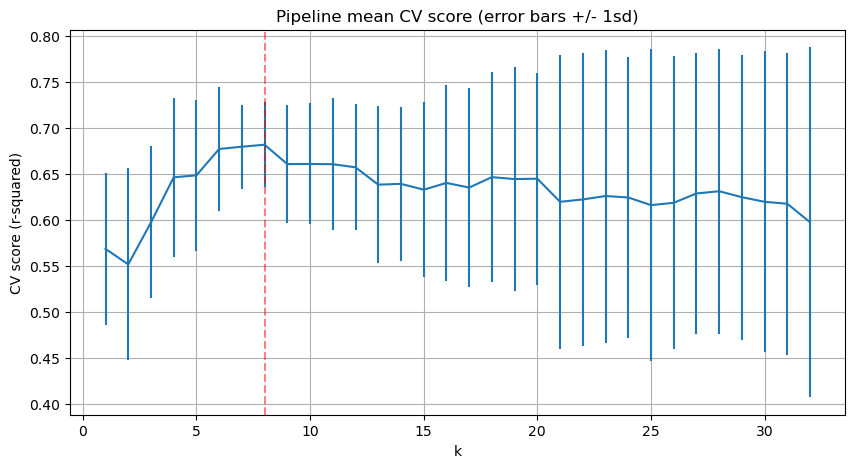

In [93]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.grid()
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The above suggests a good value for k is 8. There was an initial rapid increase with k, followed by a slow decline. Also noticeable is the variance of the results greatly increase above k=8. As you increasingly overfit, expect greater swings in performance as different points move in and out of the train/test folds.

Which features were most useful? Step into your best model, shown below. Starting with the fitted grid search object, you get the best estimator, then the named step 'selectkbest', for which you can its get_support() method for a logical mask of the features selected.

The above suggests a good value for k is 8. There was an initial rapid increase with k, followed by a slow decline. Also noticeable is the variance of the results greatly increase above k=8. As you increasingly overfit, expect greater swings in performance as different points move in and out of the train/test folds.

Which features were most useful? Step into your best model, shown below. Starting with the fitted grid search object, you get the best estimator, then the named step 'selectkbest', for which you can its get_support() method for a logical mask of the features selected.

Similarly, instead of using the 'selectkbest' named step, you can access the named step for the linear regression model and, from that, grab the model coefficients via its coef_ attribute:

In [97]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [98]:
#Code task 21#
#Get the linear model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index,
#sorting the values in descending order
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

vertical_drop        10.767857
Snow Making_ac        6.290074
total_chairs          5.794156
fastQuads             5.745626
Runs                  5.370555
LongestRun_mi         0.181814
trams                -4.142024
SkiableTerrain_ac    -5.249780
dtype: float64

These results suggest that vertical drop is your biggest positive feature. This makes intuitive sense and is consistent with what you saw during the EDA work. Also, you see the area covered by snow making equipment is a strong positive as well. People like guaranteed skiing! The skiable terrain area is negatively associated with ticket price! This seems odd. People will pay less for larger resorts? There could be all manner of reasons for this. It could be an effect whereby larger resorts can host more visitors at any one time and so can charge less per ticket. As has been mentioned previously, the data are missing information about visitor numbers. Bear in mind, the coefficient for skiable terrain is negative for this model. For example, if you kept the total number of chairs and fastQuads constant, but increased the skiable terrain extent, you might imagine the resort is worse off because the chairlift capacity is stretched thinner.

# 4.10 Random Forest Model

 A model that can work very well in a lot of cases is the random forest. For regression, this is provided by sklearn's RandomForestRegressor class.

Time to stop the bad practice of repeatedly checking performance on the test split. Instead, go straight from defining the pipeline to assessing performance using cross-validation. cross_validate will perform the fitting as part of the process. This uses the default settings for the random forest so you'll then proceed to investigate some different hyperparameters.

In [99]:
#Code task 22#
#Define a pipeline comprising the steps:
#SimpleImputer() with a strategy of 'median'
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 47
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

## 4.10.2 Fit and assess performance using cross-validation

In [100]:
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [101]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.69253776, 0.78061953, 0.77546984, 0.62192916, 0.61742339])

In [102]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.6975959370463757, 0.07090267437132815)

## 4.10.3 Hyperparameter search using GridSearchCV

Random forest has a number of hyperparameters that can be explored, however here you'll limit yourselves to exploring some different values for the number of trees. You'll try it with and without feature scaling, and try both the mean and median as strategies for imputing missing values.

In [103]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [104]:
#Call `GridSearchCV` with the random forest pipeline, passing in the above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [105]:
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [106]:
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 69,
 'simpleimputer__strategy': 'median',
 'standardscaler': None}

It looks like imputing with the median helps, but scaling the features doesn't.

In [107]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.6951357 , 0.79430697, 0.77170917, 0.62254707, 0.66499334])

You've marginally improved upon the default CV results. Random forest has many more hyperparameters you could tune, but we won't dive into that here.

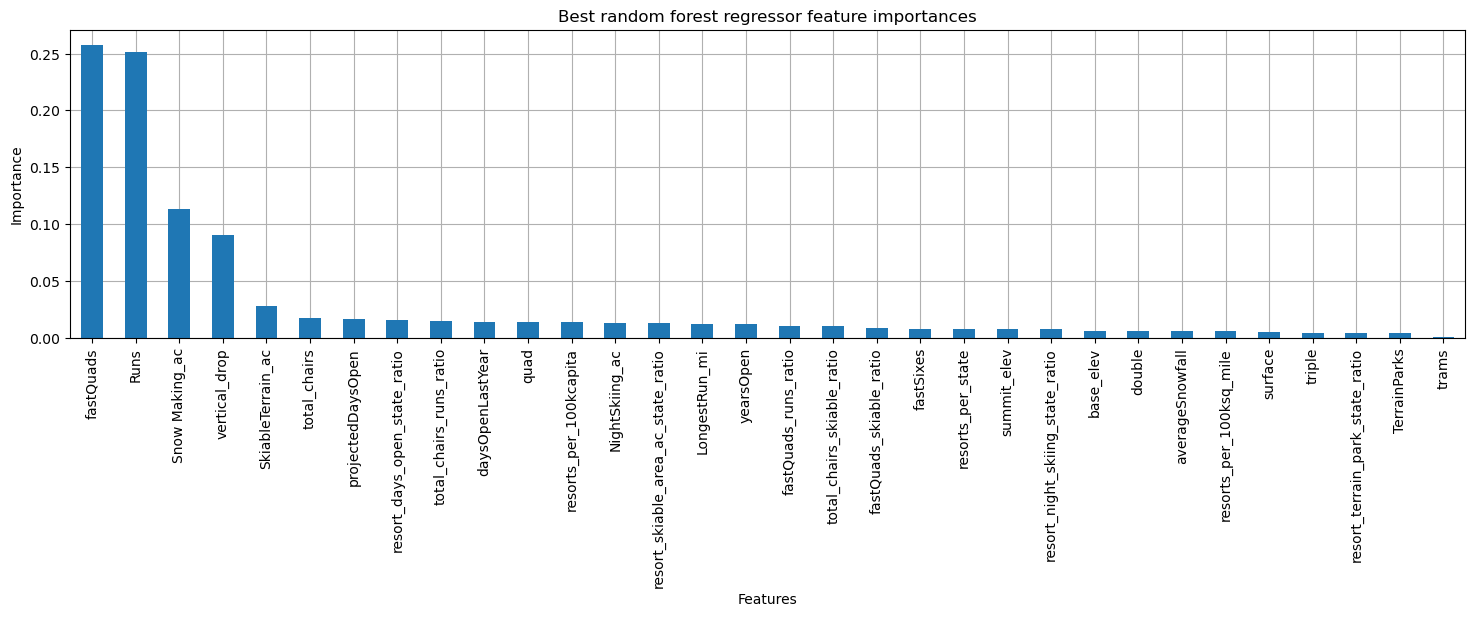

In [108]:
#Plot a barplot of the random forest's feature importances,
#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
plt.subplots(figsize=(18, 4))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
plt.grid(True)
ax = rf_feat_imps.plot(kind='bar', grid=True)
ax.set_axisbelow(True) 
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Best random forest regressor feature importances');

Encouragingly, the dominant top four features are in common with your linear model:

fastQuads
Runs
Snow Making_ac
vertical_drop

# 4.11 Final Model Selection

Time to select your final model to use for further business modeling! It would be good to revisit the above model selection; there is undoubtedly more that could be done to explore possible hyperparameters. It would also be worthwhile to investigate removing the least useful features. Gathering or calculating, and storing, features adds business cost and dependencies, so if features genuinely are not needed they should be removed. Building a simpler model with fewer features can also have the advantage of being easier to sell (and/or explain) to stakeholders. Certainly there seem to be four strong features here and so a model using only those would probably work well. However, you want to explore some different scenarios where other features vary so keep the fuller model for now. The business is waiting for this model and you have something that you have confidence in to be much better than guessing with the average price.

Or, rather, you have two "somethings". You built a best linear model and a best random forest model. You need to finally choose between them. You can calculate the mean absolute error using cross-validation. Although cross-validate defaults to the  𝑅2
  metric for scoring regression, you can specify the mean absolute error as an alternative via the scoring parameter.

## 4.11.1 Linear regression model performance

In [109]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [110]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(10.499032338015294, 1.6220608976799664)

In [111]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

11.793465668669326

# 4.11.2 Random forest regression model performance

In [112]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [113]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(9.644639167595688, 1.3528565172191818)

In [114]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

9.532666317443688

# 4.11.3 Conclusion

The random forest model has a lower cross-validation mean absolute error by almost $1. It also exhibits less variability. Verifying performance on the test set produces performance consistent with the cross-validation results.

# 4.12 Data quantity assessment

Finally, you need to advise the business whether it needs to undertake further data collection. Would more data be useful? We're often led to believe more data is always good, but gathering data invariably has a cost associated with it. Assess this trade off by seeing how performance varies with differing data set sizes. The learning_curve function does this conveniently.

In [115]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

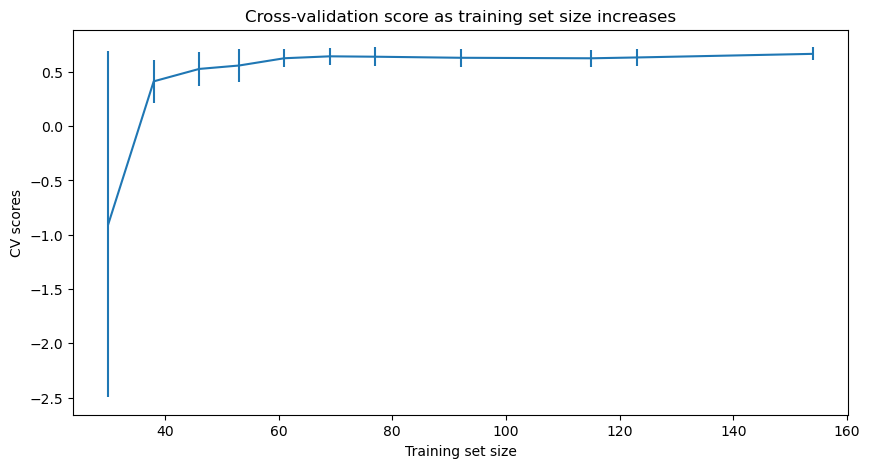

In [116]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

This shows that you seem to have plenty of data. There's an initial rapid improvement in model scores as one would expect, but it's essentially levelled off by around a sample size of 40-50.

# 4.13 Save best model object from pipeline


In [117]:
#This may not be "production grade ML deployment" practice, but adding some basic
#information to your saved models can save your bacon in development.
#Just what version model have you just loaded to reuse? What version of `sklearn`
#created it? When did you make it?
#Assign the pandas version number (`pd.__version__`) to the `pandas_version` attribute,
#the numpy version (`np.__version__`) to the `numpy_version` attribute,
#the sklearn version (`sklearn_version`) to the `sklearn_version` attribute,
#and the current datetime (`datetime.datetime.now()`) to the `build_datetime` attribute
#Let's call this model version '1.0'
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [118]:
# save the model

modelpath = '../models'
save_file(best_model, 'ski_resort_pricing_model.pkl', modelpath)

Directory ../models was created.
Writing file.  "../models\ski_resort_pricing_model.pkl"


# 4.14 Summary

Q: 1 Write a summary of the work in this notebook. Capture the fact that you gained a baseline idea of performance by simply taking the average price and how well that did. Then highlight that you built a linear model and the features that found. Comment on the estimate of its performance from cross-validation and whether its performance on the test split was consistent with this estimate. Also highlight that a random forest regressor was tried, what preprocessing steps were found to be best, and again what its estimated performance via cross-validation was and whether its performance on the test set was consistent with that. State which model you have decided to use going forwards and why. This summary should provide a quick overview for someone wanting to know quickly why the given model was chosen for the next part of the business problem to help guide important business decisions.

What I feel about the whole project :
    We use first step in developing a model was to examine performance by using the "mean of prices". This proved to be helpful in establishing a baseline for comparison, however it was not as useful or as accurate as a linear model or random forest model. If you predicted ticket price by using the mean, on average you would be off by about $19.

In the process of building the linear model, missing values were imputed with the median and mean values. If ticket prices were predicted using the linear model, they would be off by about $9. However, the initial linear model was overfitting and needed to be adjusted by the number of features. Through cross-validation, the value of k was set to eight features to focus on: vertical_drop, Snow Making_ac, total_chairs, fastQuads, Runs, LongestRun_mi, trams, and SkiableTerrain_ac. These features fit our initial assumptions from EDA.

In addition to the linear model, a random forest model was developed. Like the linear model, missing values were imputed with the median and mean values. While imputing the median was helpful, it was not helpful to scale the features. The random forest model revealed that the top four features to consider are fastQuads, Runs, Snow Making_ac, and vertical_drop.

After testing both the linear model and random forest model, the project will be moving forward with the forest regression model. Comparison of the two demonstrated that performance on the test set was consistent cross-validation results. Additionally, the cross-validation mean absolute error was lower using the random forest regressor.

My view since, the Random Forest Model had the lower absolute error with just about $1. This, along with it’s low variability makes it the best model for Big Mountain Resort. It’s consistent with cross-validation results and produces a good, fair price.